In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Chicago Street Center Lines

I have recently been alerted to the existance of a different dataset for street network data, rather than using the TIGER/Lines data.

It is available on the [Chicago Data Portal](https://catalog.data.gov/dataset/street-center-lines)

- There is, typically, very little contextual information
- The first ZIP file download is a standard shapefile (notice that the URL contained "shapefile").

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import scipy.spatial
import os, collections, lzma, datetime
import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.network
import impute.chicago
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
filename = os.path.join(datadir, "Chicago_Street Center Lines")

streets = gpd.io.file.read_file(filename)
streets.crs

{'init': 'epsg:4326'}

### Initial clean

Couple of rows with junk geometry.  They seem to be totally junk rows.

In [4]:
streets[streets.geometry.map(lambda t : t is None)].T

,56286,56307
class,None,None
create_use,None,None
date_creat,1899-11-30,1899-11-30
date_statu,1899-11-30,1899-11-30
date_updat,1899-11-30,1899-11-30
dir_travel,None,None
edit_date,0,0
edit_type,None,None
ewns,0,0
ewns_coord,0,0


In [5]:
streets = streets[streets.geometry.map(lambda t : t is not None)]

### Look at columns

In [6]:
row = streets.ix[100]
row

class                                                         4
create_use                                             EXISTING
date_creat                                           1999-01-01
date_statu                                           1999-01-01
date_updat                                           1999-01-01
dir_travel                                                    B
edit_date                                                     0
edit_type                                                  None
ewns                                                      -4700
ewns_coord                                                 4700
ewns_dir                                                      W
f_cross                                         4700|W|82ND|PL|
f_cross_st                                                 1981
f_zlev                                                        0
flag_strin                                                 None
fnode_id                                

From browsing around in QGIS, I think we can infer the following fields as being important:

    f_cross
    f_cross_st
    fnode_id
    length
    shape_len
    street_nam
    street_typ
    pre_dir
    streetname
    t_cross
    t_cross_st
    tnode_id
    l_f_add
    l_t_add
    l_parity
    r_f_add
    r_t_add
    r_parity    

In [7]:
columns_want = ["f_cross", "f_cross_st", "fnode_id", "length",
    "shape_len", "street_nam", "street_typ", "streetname", "t_cross",
    "t_cross_st", "tnode_id", "pre_dir", "l_f_add", "l_t_add", "l_parity",
    "r_f_add", "r_t_add", "r_parity"]
reduced_streets = gpd.GeoDataFrame(streets[columns_want])
reduced_streets.geometry = streets.geometry
reduced_streets.crs = streets.crs
reduced_streets.head()

,f_cross,f_cross_st,fnode_id,length,shape_len,street_nam,street_typ,streetname,t_cross,t_cross_st,tnode_id,pre_dir,l_f_add,l_t_add,l_parity,r_f_add,r_t_add,r_parity,geometry
0,245|W|ENGLEWOOD|AVE|,2208.0,10809.0,220.566014,220.566012,YALE,AVE,1782.0,6250|S|||,0.0,16581.0,S,0.0,0.0,O,6228.0,6248.0,E,LINESTRING (-87.63187018233509 41.780809747581...
1,800|E|73RD|ST|,170.0,6501.0,664.774635,664.774607,COTTAGE GROVE,AVE,1236.0,800|E|74TH|ST|,172.0,34082.0,S,7301.0,7359.0,O,7300.0,7358.0,E,LINESTRING (-87.60548932047928 41.762229643527...
2,2500|W|108TH|ST|,1803.0,15338.0,665.378484,665.378453,CAMPBELL,AVE,1177.0,2500|W|109TH|ST|,1805.0,22358.0,S,10801.0,10859.0,O,10800.0,10858.0,E,LINESTRING (-87.6838184819274 41.6972438444297...
3,11024|S|||,0.0,15799.0,152.564889,152.564966,SANGAMON,ST,1696.0,||DEAD END||,0.0,28881.0,S,0.0,0.0,O,11026.0,11032.0,E,LINESTRING (-87.64584189298007 41.693398400444...
4,11800|S|VINCENNES|AVE|,1752.0,36407.0,332.691371,332.691382,118TH,ST,1823.0,11799|S|CHURCH|ST|,1214.0,36534.0,W,1933.0,1959.0,O,1932.0,1958.0,E,LINESTRING (-87.67053671319235 41.679759274890...


In [8]:
reduced_streets.to_file(os.path.join(datadir, "Chicago reduced streets"))

# Data format

- The street name is `pre_dir` `street_nam` `street_typ`
- `streetname` is just an integer id, but it is _shared_ by all edges in the same street.
- Below, we will see that `shape_len` is the length in [US survery feet](https://en.wikipedia.org/wiki/Foot_(unit&#41;#US_survey_foot) of the geometry.  `length` is sometimes identical, and sometimes a bit longer or shorter.  I have not been able to tell why.
- `f_cross_st` is the `streetname` id of edge at the "from" side of the edge
- `fnode_id` is an integer id of the vertex at the "from" side of the edge
- `f_cross` appears to be four fields separated by `|` characters.
  - The first field is a number, which I think is the starting block address (of the "from" street)
  - The rest of the fields can be combined to form the street name of the "from" street
- Similarly for `t_cross`, `t_cross_st` and `tnode_id`
  - Some long edges are split into parts.  If this happens, then the "interior" nodes will have `0` as the `_cross_st` and an incomplete `_cross` data.
  - There are a few errors here, see below
- `l_f_add`, `l_t_add`, `l_parity` contains details about the "left" (facing in the direction of "from" to "to") addresses.
- Similarly for `r_f_add`, `r_t_add`, `r_parity`

### Check streetnames

- Check each `streetname` corresponds to exactly one combination of `pre_dir` `street_nam` `street_typ`
- Sometimes `pre_dir` can be `None`; as can `street_typ`
- Sometimes `street_nam` can be `None`.  It seems this is a bit of a placeholder (`streetname`==1 for some disjoint edges, for example).

In [9]:
streetname_lookup = collections.defaultdict(set)
for rowid, row in streets.iterrows():
    street_data = []
    for x in [row.pre_dir, row.street_nam, row.street_typ]:
        if x is not None:
            street_data.append(x)
        else:
            street_data.append("")
    description = "|".join(street_data)
    streetname_lookup[ int(row.streetname) ].add(description)

assert all(len(x)==1 for x in streetname_lookup.values())

In [10]:
streetname_lookup = {i : list(v)[0] for i, v in streetname_lookup.items()}

### Check this agrees with `f_cross_` etc.

They don't of course...

In [11]:
for rowid, row in streets.iterrows():
    if int(row.f_cross_st) == 0:
        if not (row.f_cross.endswith("|||") or row.f_cross == "||DEAD END||"):
            print("Odd: '{}'".format(row.f_cross))

Odd: '9919|S|CHICAGO SKYWAY|EXPY|'
Odd: '10012|S|CHICAGO SKYWAY|EXPY|'
Odd: '0| | | |'
Odd: '0| | | |'
Odd: '8300|S|CHICAGO SKYWAY|EXPY|'
Odd: '10199|W|KENNEDY|EXPY|'
Odd: '0|S|MIDWAY AIRPORT LOWER| |'


In [12]:
for rowid, row in streets.iterrows():
    if int(row.t_cross_st) == 0:
        if not (row.t_cross.endswith("|||") or row.t_cross == "||DEAD END||"):
            print("Odd: '{}'".format(row.t_cross))

Odd: '4217|S|PRIVATE| |'
Odd: '10012|S|CHICAGO SKYWAY|EXPY|'
Odd: '1600|S|CHICAGO RIVER| |'
Odd: '5827|N|DES PLAINES RIVER| |'
Odd: '5833|N|DES PLAINES RIVER| |'
Odd: '239|W|EISENHOWER|EXPY|'
Odd: '9733|W|KENNEDY|EXPY|'
Odd: '3300|N|DES PLAINES RIVER| |'
Odd: '5200|N|DES PLAINES RIVER| |'


In [13]:
from_to_lookup = collections.defaultdict(set)
for rowid, row in streets.iterrows():
    for id_field, name_field in [(row.f_cross_st, row.f_cross), (row.t_cross_st, row.t_cross)]:
        if int(id_field) != 0:
            assert name_field.endswith("|")
            name = "|".join( [x.strip() for x in name_field.split("|")[1:-1]] )
            if name.endswith("||"):
                # These are errors, I think
                continue
            from_to_lookup[int(id_field)].add(name)

In [14]:
for k, v in from_to_lookup.items():
    if len(v) > 1:
        print(k, v)

1438 {'S|LAKE SHORE|DR', 'S|I57 119TH ST|ER'}
1425 {'S|HOXIE|AVE', 'S|KOSTNER|AVE'}
481 {'N|EDENS OB|ER', 'N|EAST RIVER|RD'}
1249 {'S|DAN RYAN 18TH ST|ER', 'S|DREXEL|BLVD'}


In [15]:
# Where the street name differs from the name given by the from/to data
for street_id, name in streetname_lookup.items():
    if street_id in from_to_lookup:
        if not name in from_to_lookup[street_id]:
            print(street_id, name, from_to_lookup[street_id])

292 E|MADISON PARK| {'E|MADISON AVENUE PARK|'}
1569 S|LINN WHITE|DR {'S|LYNN WHITE|DR'}
5527 N|TWYH3|ORD {'W|TWYH3|ORD'}


In [16]:
# Where from/to data gives an id which doesn't otherwise exist!
for street_id, names in from_to_lookup.items():
    if street_id not in streetname_lookup:
        print(street_id, names)

1293 {'S|DAN RYAN IB FRANKLIN EXT|XR'}
2243 {'W|FULLERTON|DR'}
1259 {'S|DAN RYAN 51ST ST|ER'}
1289 {'S|DAN RYAN FRANKLIN|ER'}
1260 {'S|DAN RYAN 51ST ST|XR'}
1473 {'S|KENNEDY I57|XR'}
1302 {'S|DAN RYAN OB STEVENSON OB|ER'}
1225 {'S|DAMEN|AVE'}
2153 {'W|DOUGLAS|DR'}
689 {'N|LAKE SHORE LOWER|DR'}


### Look at length

In [17]:
frame = streets.to_crs({"init":"epsg:3528"})

In [18]:
calculated_lengths = np.asarray(frame.geometry.map(lambda g : g.length))
np.testing.assert_allclose(calculated_lengths, frame["shape_len"] * 1200 / 3937)

In [19]:
x = calculated_lengths - frame["length"] * 1200 / 3937
x = np.sort(x)
x

array([ -9.50866479,  -7.81140429,  -6.67931939, ...,   8.16818047,
        10.82777275,  81.89063559])

### Check vertex ids match up

`fnode_id` and `tnode_id` should match with geometry.

- There is _one_ slight numerical error.  Gwrrr.

In [20]:
nodes = collections.defaultdict(set)
for rowid, row in streets.iterrows():
    assert row.geometry.geom_type == "LineString"
    g = np.asarray(row.geometry)
    nodes[int(row.fnode_id)].add(tuple(g[0]))
    nodes[int(row.tnode_id)].add(tuple(g[-1]))

In [21]:
close_count = 0
for node_id, pts in nodes.items():
    if len(pts) == 1:
        continue
    pts = np.asarray(list(pts))
    distances = scipy.spatial.distance.pdist(pts)
    assert np.max(distances) < 1e-10
    close_count += 1
close_count

1

The following shows that a lot of geographical points have 2 node ids associated with them.  For the _most_ pat, these seem to reflect real geographical features: for example, an over/under pass where on id is associated with the "under" node, and the other id with the "over" node.  That is, we almost certainly do not wish to "join" these vertices, as then we'd create a path which didn't in reality exist.

Sadly, there are a few errors.  The following are two examples:
    
    (-87.728703564678838, 41.774974884371751) {(13410, '65TH'), (15084, 'TRIPP'), (15084, '65TH')}
    (-87.661957173554228, 41.880249542148633) {(20089, 'LOOMIS'), (20518, 'LOOMIS'), (20089, 'MONROE')}
    
In these cases, from examining a base map, we find that the vertices _should_ be joined together.

This leads us with a problem:

- It would be more correct to _not_ join these vertices.
- But doing this would lead to a small number of genuine errors, disconnected regions of the graph, etc.

For the moment, this doesn't really matter.

In [22]:
from_geo_to_node_id = collections.defaultdict(set)
for rowid, row in streets.iterrows():
    g = np.asarray(row.geometry)
    for pt, node_id, name in [(tuple(g[0]), int(row.fnode_id), row.street_nam),
                             (tuple(g[-1]), int(row.tnode_id), row.street_nam)]:
        from_geo_to_node_id[pt].add((node_id, name))
    
for pt, node_ids in from_geo_to_node_id.items():
    if len(set(n for n, _ in node_ids)) > 1:
        print(pt, node_ids)

(-87.555829721577823, 41.728195603416779) {(21583, '92ND'), (4710, 'CHICAGO SKYWAY')}
(-87.55555901735913, 41.728199442762339) {(20631, 'CHICAGO SKYWAY'), (17262, '92ND')}
(-87.696204473121526, 41.94669596936766) {(10425, 'N BRANCH CHICAGO RIVER'), (8872, 'ADDISON')}
(-87.667813891451857, 41.915557727148659) {(11110, 'ASHLAND'), (15119, 'KENNEDY')}
(-87.643487277247999, 41.848453898448824) {(15601, 'ARCHER'), (770, 'DAN RYAN')}
(-87.643667953016973, 41.84840389720496) {(27283, 'ARCHER'), (30696, 'DAN RYAN')}
(-87.623680246727531, 41.848066270420766) {(19667, 'MICHIGAN'), (1020, 'STEVENSON')}
(-87.623676877459999, 41.847840383746501) {(19675, 'MICHIGAN'), (1038, 'STEVENSON STATE ST'), (1038, 'STEVENSON KING DR'), (1038, 'STEVENSON')}
(-87.645537158223661, 41.877968011978261) {(4625, 'JACKSON'), (33935, 'KENNEDY')}
(-87.645456118509784, 41.876695587307374) {(17247, 'VAN BUREN'), (18023, 'KENNEDY')}
(-87.728703564678838, 41.774974884371751) {(15084, '65TH'), (13410, '65TH'), (15084, 'TRIP

# Put into our graph class

In [23]:
all_nodes = []
frame = streets.to_crs({"init":"epsg:3528"})
for rowid, row in frame.iterrows():
    for pt in np.asarray(row.geometry):
        all_nodes.append(pt)

In [24]:
b = open_cp.network.PlanarGraphNodeOneShot(all_nodes, tolerance=1e-6)
name_lookup = collections.defaultdict(set)
for rowid, row in frame.iterrows():
    street_data = []
    for x in [row.pre_dir, row.street_nam, row.street_typ]:
        if x is not None:
            street_data.append(x)
        else:
            street_data.append("")
    name = "|".join(street_data)
    geo = np.asarray(row.geometry)
    for e in b.add_path(geo):
        assert not e[0] == e[1]
        name_lookup[e].add(name)

In [25]:
graph = b.build()

In [26]:
names = collections.defaultdict(set)
for e, ns in name_lookup.items():
    index, _ = graph.find_edge(*e)
    names[index].update(ns)

## Compare to crime data

A lot of noise.  Much like the findings with the TIGER/Lines geometry, a human could probably cut down most, but not _all_ of this.

In [13]:
def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt") as f:
        for row in impute.chicago.load_only_with_point(f):
            if row.datetime > datetime.datetime(2002,1,1):
                yield row
            
next( gen() )

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [28]:
block_to_points = collections.defaultdict(set)
for row in gen():
    block_to_points[row.address].add( proj(*row.point) )

In [29]:
import re
def normalise(name):
    name = name.upper()
    name = name.replace(" MC ", " MC")
    if name.endswith(" AV"):
        name = name[:-2] + "AVE"
    
    return name

assert normalise("N BOB AV") == "N BOB AVE"

In [30]:
unusual = []
for name, pts in block_to_points.items():
    edges = []
    for pt in pts:
        (k1, k2), _ = graph.project_point_to_graph(*pt)
        e, _= graph.find_edge(k1, k2)
        edges.append(e)
    edges = collections.Counter(edges)
    edge_names = collections.defaultdict(int)
    for e, count in edges.items():
        for n in names[e]:
            n = " ".join(n.split("|")).strip()
            edge_names[n] += count
    expected_name = normalise(" ".join(name.split(" ")[1:]))
    if len(edge_names) == 1 and list(edge_names)[0] == expected_name:
        continue
    if expected_name in edge_names:
        continue
    if any(expected_name.startswith(n) for n in edge_names):
        continue
    unusual.append((edge_names, expected_name))
len(unusual)

5122

In [31]:
unusual[:5]

[(defaultdict(int, {'S CHICAGO SKYWAY EXPY': 2}), 'S CHICAGO SKYWAY IB'),
 (defaultdict(int, {'W FULLERTON PKWY': 13}), 'W FULLERTON DR'),
 (defaultdict(int, {'E 133RD ST': 2, 'E 134TH ST': 1, 'S DOBSON AVE': 19}),
  'S GREENWOOD AVE'),
 (defaultdict(int, {'S DAN RYAN EXPY': 1}), 'S DAN RYAN LOCAL IB'),
 (defaultdict(int, {'N SACRAMENTO BLVD': 1}), 'N SACRAMENTO SD')]

# Work with the geometry directly

Don't pre-process into a `graph` class.

Firstly we re-create the above, now with added address data.  The level of noise seems similar.

In [17]:
import rtree, shapely.geometry

geometry = [shapely.geometry.LineString( np.asarray(proj(*row.line.T)).T )
    for row in impute.chicago.load_street_centre_lines(filename)]
street_data = list( impute.chicago.load_street_centre_lines(filename) )

In [31]:
def index_gen():
    for i, geo in enumerate(geometry):
        yield i, geo.bounds, None
        
index = rtree.index.Index(index_gen())

In [62]:
def possible_block(block_number):
    s = str(block_number)
    if len(s) > 2:
        s = s[:-2] + "XX"
    else:
        s = "0X"
    return "0" * (5-len(s)) + s
    
assert possible_block(23) == "0000X"
assert possible_block(123) == "001XX"
assert possible_block(4321) == "043XX"

def possible_blocks(street_row):
    numbers = [street_row.left.start, street_row.left.end,
            street_row.right.start, street_row.right.end]
    return { possible_block(x) for x in numbers if x > 0 }

In [63]:
d=0.1
for row in gen():
    x, y = proj(*row.point)
    pt = shapely.geometry.Point(x, y)
    choices = list(index.intersection((x-d,y-d,x+d,y+d)))
    dists = [geometry[i].distance(pt) for i in choices]
    i = choices[np.argmin(dists)]
    street_row = street_data[i]
    generated = { x + " " + street_row.street_name
        for x in possible_blocks(street_row) }
    if len(generated) == 1 and row.address in generated:
        continue
    break

In [64]:
street_row

Street(street_id=828, street_name='N MCVICKER AVE', length=284.057125799238, source=StreetNode(street_id=2143, node_id=22510, street_address='6031|W|DICKENS|AVE|'), destination=StreetNode(street_id=0, node_id=22502, street_address='2201|N|||'), left=StreetAddress(start=2100, end=2186, parity='E'), right=StreetAddress(start=2101, end=2187, parity='O'), line=array([[-87.77673224,  41.91789445],
       [-87.77675659,  41.91861973],
       [-87.77677985,  41.91931293],
       [-87.77680355,  41.92000613],
       [-87.77681289,  41.92029116],
       [-87.77681645,  41.92039982],
       [-87.77681813,  41.92045107]]))

In [65]:
row.address

'021XX N MC VICKER AVE'

In [66]:
generated

{'021XX N MCVICKER AVE'}

**Secondly** we look at each edge in the input data, and find the points which map to that edge.

- A significant fraction of points (but still small overall) do not map to any (close enough) edge.

In [91]:
street_index_to_blocks = collections.defaultdict(set)
street_index_to_pts = collections.defaultdict(set)
cannot_map = []

for row in gen():
    x, y = proj(*row.point)
    pt = shapely.geometry.Point(x, y)
    d = 20
    choices = list(index.intersection((x-d,y-d,x+d,y+d)))
    if len(choices) == 0:
        cannot_map.append(row)
    else:
        dists = [geometry[i].distance(pt) for i in choices]
        i = choices[np.argmin(dists)]
        street_index_to_blocks[i].add(row.address)
        street_index_to_pts[i].add(row.point)

In [92]:
len(cannot_map)

3105

In [93]:
cannot_map[0]

Row(id='5193782', crime_type='CRIMINAL DAMAGE', crime_subtype='TO PROPERTY', location='CHA PARKING LOT/GROUNDS', address='133XX S GREENWOOD AVE', datetime=datetime.datetime(2006, 12, 15, 0, 56), point=(-87.594955556, 41.652945477))

In [94]:
list(street_index_to_blocks.items())[:5]

[(50453, {'108XX S AVENUE G'}),
 (29852, {'060XX S WOLCOTT AV', '060XX S WOLCOTT AVE'}),
 (13179, {'014XX E 74TH ST'}),
 (38234, {'006XX E 90 PL', '006XX E 90TH PL'}),
 (42243, {'040XX N KIMBALL AV', '040XX N KIMBALL AVE'})]

In [95]:
for i, _ in zip(street_index_to_blocks, range(5)):
    print(i, street_data[i].street_name)

50453 S AVENUE G
29852 S WOLCOTT AVE
13179 E 74TH ST
38234 E 90TH PL
42243 N KIMBALL AVE


[(587066.60147632612, 587366.60147632612),
 (351286.80976014101, 351586.80976014101)]

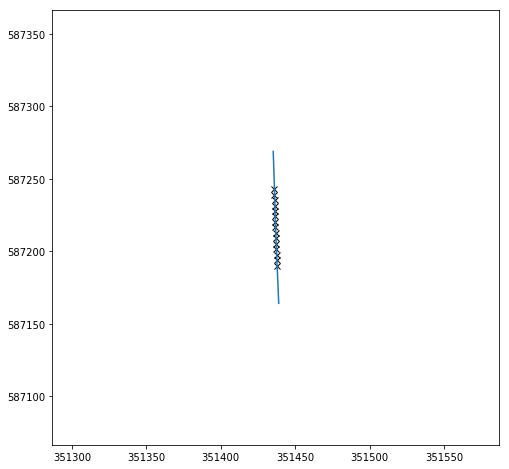

In [111]:
import matplotlib.collections
fig, ax = plt.subplots(figsize=(8,8))

i = 42243
pts = np.asarray(list(street_index_to_pts[i]))
pts = np.asarray(proj(*pts.T))
ax.scatter(*pts, marker="x", color="black", linewidth=1)

lc = matplotlib.collections.LineCollection( [ geometry[i] ] )
ax.add_collection(lc)

d = 150
x, y = np.mean(pts, axis=1)
ax.set(xlim=[x-d,x+d], ylim=[y-d,y+d])

Again, a _conjecture_ is that all the edges should look like this: a contiguous bunch of markers in the middle of the edge.

- I know this won't be completely the case, from QGIS examples
- An _advantage_ over the TIGER/Lines data is that we haven't had to remove edges like alleyways.